In [1]:
from __future__ import print_function
import sys,os,datetime
import cv2 as cv
import cv2 as cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
import csv

In [2]:
print('openCV',cv.__version__)
print('numpy',np.__version__)

openCV 3.2.0
numpy 1.13.3


In [3]:
dirTrain1 = '../Data/train/train/level-1'
dirTrain2 = '../Data/train/train/level-2'
dirTrain3 = '../Data/train/train/level-3'
dirTrain  = dirTrain2
dirDev    = '../Data/dev/dev'

In [4]:
def NNTrain(dirTrain) :
    listTrain= os.listdir(dirTrain); len(listTrain); listTrain[:12]
    listTrainNN = []
    for ff in listTrain :
        if ff.lower().endswith('.txt') : listTrainNN.append(ff.split('_')[0])
    return(listTrainNN)
listTrainNN = NNTrain(dirTrain)
len(listTrainNN), listTrainNN[:15]

(1495,
 ['1003',
  '1009',
  '100',
  '1012',
  '1018',
  '1021',
  '984',
  '994',
  '995',
  '997',
  '9',
  '952',
  '955',
  '956',
  '959'])

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-1
751 302 213.09587217 36.0 489.453206012 0.140102480059 1.72123602893


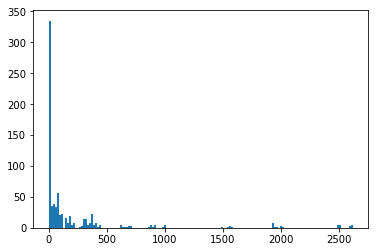

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-2
1495 540 258.478929766 47.0 544.611454936 0.169940124764 1.72846811308


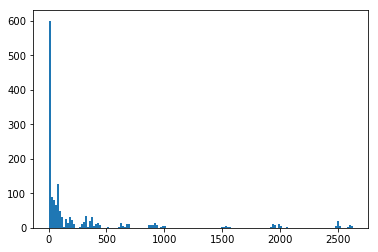

(390, 390, 3) (500, 500, 3) (390, 390) ../Data/train/train/level-3
1873 540 258.515750133 60.0 542.370915742 0.169964332764 1.7258382643


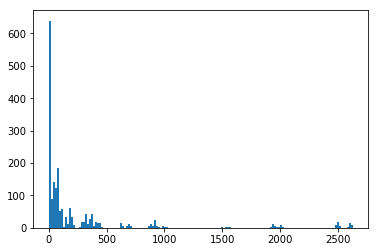

In [5]:
# Build statistics on masks
for dirTrain in (dirTrain1,dirTrain2,dirTrain3) :
    listTrainNN = NNTrain(dirTrain)
    maskSize = []
    for NN in range(len(listTrainNN)) :
        #print(NN)
        img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
        img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
        img3 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_mask.tif'),-1)
        maskSize.append(img3[img3>0.5].size)
        #img1      = cv.GaussianBlur(img1,(3,3),0)
        #img2      = cv.GaussianBlur(img2,(3,3),0)
    print(img1.shape,img2.shape,img3.shape, dirTrain)
    
    maskSize = np.array(maskSize)
    print(len(maskSize), len(maskSize[maskSize==0]), maskSize.mean(), np.median(maskSize), maskSize.std(), maskSize.mean()/(390*390)*100.0, float(maskSize.max())/(390*390)*100.0)
    plt.hist(maskSize,bins=150); plt.show()

In [6]:
def diffPicts (img1, img2) :
    diff = []
    for cc in range(img1.shape[2]) :
        ccc   = np.abs(img1[:,:,cc]-img2[:,:,cc])
        cccL2 = np.sqrt(np.square(ccc).mean())
        cccL1 = ccc.max()
        diff.append([cccL1,cccL2,ccc])
    diffL2 = np.zeros(ccc.shape)
    for L1,L2,ccc in diff : diffL2 += np.square(ccc)
    diffL2 = np.sqrt(diffL2)
    return(diff,diffL2)

def minDeltaRC (img1,img2, ranging=range(-5,6), printOK=False) :
    r0,c0 = (img2.shape[0]-img1.shape[0])/2, (img2.shape[1]-img1.shape[1])/2
    minL2 = [390*390*250.0,0,0]
    for dr in ranging :
        for dc in ranging :
            imgX2 = img2[r0+dr:r0+img1.shape[0]+dr,c0+dc:c0+img1.shape[1]+dc,:]
            diff, L2 = diffPicts(img1,imgX2)
            if (minL2[0]>L2.mean()) : minL2 = (L2.mean(),dr,dc,r0+dr,c0+dc)
            if printOK : print (dr,dc,'\t',minL2[0],'\t',L2.max(),L2.mean(),L2.std(),np.median(L2))
    return(minL2)

print('min=',minDeltaRC(img1,img2))

min= (8.7705751775521197, 0, 1, 55, 56)


In [7]:
def pictNorm (img255, std=False) :
    imgF32 = np.float32(img255) 
    for cc in range(img255.shape[2]) :
        imgF32[:,:,cc] -= imgF32[:,:,cc].mean()
        if std : imgF32[:,:,cc] /= imgF32[:,:,cc].std()**2
        imgF32[:,:,cc] /= 127.0
    return(imgF32)

In [8]:
def computeORB (img, debug=False) :
    orb    = cv2.ORB_create();
    kp     = orb.detect(img,None)
    kp,des = orb.compute(img,kp)
    if debug :
        print (len(kp))
        print (len(des),len(des[0]),"\n",des[0],"\n",des[1])
    return kp,des

def computeMatches (des1,des2) :
    if True :
        bf      = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
        matches = bf.match(des1,des2);
        #????matches = bf.knnMatch(des1,des2,k=1);
    if False :
        index_params = dict(algorithm = 6, #cv2.FLANN_INDEX_LSH,
                            table_number = 6, 
                            key_size = 12,    
                            multi_probe_level = 1)
        search_params = dict(checks=100)
        flann   = cv2.FlannBasedMatcher(index_params,search_params)
        matchesI = flann.knnMatch(des1,des2,k=3);
        matches  = [];
        for mI in matchesI :
            for m in mI : matches.append(m);
    return matches    

def drawMatches(img1,kp1,des1,img2,kp2,des2, show=False, showNN=20):
    matches = computeMatches(des1,des2);
    matches = sorted(matches,key=lambda x:x.distance)
    if  show :
        imgM    = img1.copy()
        #imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:20],imgM,flags=4)
        imgM    = cv2.drawMatches(img1,kp1,img2,kp2,matches[:showNN],imgM,flags=2) #4)
        #imgM    = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,imgM,flags=2) #4)
        
        plt.figure(figsize=(15,15)); plt.imshow(imgM), plt.show()
    return(matches)


In [16]:
len(listTrainNN)

1873

In [28]:
X1 = np.zeros((len(listTrainNN),)+img1.shape,dtype=np.float32)
X2 = np.zeros((len(listTrainNN),)+img1.shape,dtype=np.float32)
YY = np.zeros((len(listTrainNN),)+img3.shape+(1,),dtype=np.float32)
X1.shape, X2.shape,YY.shape

((1873, 390, 390, 3), (1873, 390, 390, 3), (1873, 390, 390, 1))

In [40]:
print(datetime.datetime.now())
NN = 172
for NN in range(len(listTrainNN)) :
    img1 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'.tif'),-1)
    img2 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_ref.tif'),-1)
    img3 = cv.imread(os.path.join(dirTrain,listTrainNN[NN]+'_mask.tif'),-1); img3 = img3.reshape(img3.shape+(1,))
    
    if 1 :
        img1 = cv2.GaussianBlur(img1,(3,3),0)
        img2 = cv2.GaussianBlur(img2,(3,3),0)

    if 0 :
        img1 = cv2.boxFilter(img1,-1,(5,5))
        img2 = cv2.boxFilter(img2,-1,(5,5))


    if 1 :
        img1  = pictNorm(img1)
        img2  = pictNorm(img2)

    rcL2,_,_,r0,c0 = minDeltaRC(img1,img2,ranging=range(-10,10))
    img2X = img2[r0:r0+img1.shape[0],c0:c0+img1.shape[1]]
    
    if NN%100==0 : print(datetime.datetime.now(),NN,rcL2,r0,c0)

    if 0 :
        img1 = cv2.GaussianBlur(img1,(3,3),0)
        img2X = cv2.GaussianBlur(img2X,(3,3),0)

    if 0 :
        img1 = cv2.boxFilter(img1,-1,(5,5))
        img2X = cv2.boxFilter(img2X,-1,(5,5))
        
    X1[NN], X2[NN], YY[NN] = img1, img2X, img3

print(datetime.datetime.now())

2018-02-11 21:44:06.147731
2018-02-11 21:44:07.048505 0 0.0598608887135 54 56
2018-02-11 21:45:30.479790 100 0.134486529134 54 55
2018-02-11 21:46:53.248368 200 0.0878773285325 54 55
2018-02-11 21:48:15.633785 300 0.0675147180248 55 55
2018-02-11 21:49:37.780849 400 0.0942449340201 55 55
2018-02-11 21:51:00.236850 500 0.152497451952 55 55
2018-02-11 21:52:22.343436 600 0.101988462312 55 55
2018-02-11 21:53:44.627629 700 0.0629620185998 54 56
2018-02-11 21:55:07.118192 800 0.0939286680915 55 55
2018-02-11 21:56:29.148867 900 0.102856678143 55 55
2018-02-11 21:57:51.916285 1000 0.0555911989257 55 55
2018-02-11 21:59:14.205918 1100 0.0365642435006 56 55
2018-02-11 22:00:36.340140 1200 0.260966282542 54 56
2018-02-11 22:01:58.129559 1300 0.0852100445995 55 55
2018-02-11 22:03:20.090152 1400 0.0580791299991 55 54
2018-02-11 22:04:41.798471 1500 0.0816246567998 55 55
2018-02-11 22:06:03.844254 1600 0.0828377482355 56 55
2018-02-11 22:07:25.770485 1700 0.26357173239 56 54
2018-02-11 22:08:47.

In [42]:
dirForSave = '../Work'

In [44]:
if 0 :
    np.save(os.path.join(dirForSave,'X1.npy'),X1)
    np.save(os.path.join(dirForSave,'X2.npy'),X2)
    np.save(os.path.join(dirForSave,'YY.npy'),YY)

In [69]:
from keras.models import Input, Model
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Concatenate, Activation, Dropout,Add
from keras.layers import Conv2DTranspose, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
import keras
import keras.backend as K 

In [70]:
sys.path.append('../Python')
from LinkNetBoba import LinkNetBoba

In [84]:
#!/usr/local/bin/python
# -*- coding: utf-8 -*-
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
# model LinkNet realization for Keras (TensorFlow?)
#
# from: https://arxiv.org/pdf/1707.03718.pdf
# 
#   Abhishek Chaurasia, Eugenio Culurciello
#   LinkNet: Exploiting Encoder Representations for Efficient Semantic Segmentation
#
#
#
# realizate by Vladimir Sorokin
#
# For FREE use
#
#
# keys: LinkNet, Keras, Boba
#
# 2017-11-25
#
# 2017-12-11 1. The add operator in blockEncoder move after batch operator and after activation operator
#            2. Add batch operator 2th conv2 in blockEncoder   
#
# 2017-12-15 1. Fix bugs with names layers
#            2. Change last layers
#            3. Add activation parameter for last layer
#            4. Add conv2D before last layer
#
# 2018-02-11
#            1. Fix bugs
#            2. Add prefix-name parameter
#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from keras.models import Input, Model
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Concatenate, Activation, Dropout,Add
from keras.layers import Conv2DTranspose, SpatialDropout2D
from keras.layers.normalization import BatchNormalization

def LinkNetBoba (img_shape, n_out=1, depth=4, 
                 acti='elu', acti_last='sigmoid', 
                 dropout=False, batch=True, 
                 prefix='boba',printOK=False):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Encoder block
    #
    
    def blockEncoder(i, depth, maxDepth, mm, nn) :
        
        io = i
        
        #print('e 0 depth=',depth,io.shape)
        
        io = Conv2D(nn, (3, 3), strides=2, padding='same', name=prefix+"_"+'conv1d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath1d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)
        
        #print('e 1 depth=',depth,io.shape)
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv2d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath2d'+str(maxDepth-depth))(io)
        
        ii = Conv2D(nn, (1, 1), strides=2, name=prefix+"_"+'ii1d'+str(maxDepth-depth))(i)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath3d'+str(maxDepth-depth))(io) # 2017-12-11 add batch
        
        io = Add()([io, ii]); io1 = io;
        
        io = Activation(acti)(io)   # 2017-12-11 change point add before activation after batch
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv3d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath4d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        io = Conv2D(nn, (3, 3), padding='same', name=prefix+"_"+'conv4d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bath5d'+str(maxDepth-depth))(io)
        
        io = Add()([io, io1]);     # 2017-12-11 change point add before activation after batch
        
        io = Activation(acti)(io)                
        
        ##io = Concatenate()([io, io1]);
        
        return (io)
        

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Decoder block
    #
    
    def blockDecoder(i, depth, maxDepth, mm, nn) :
        
        io = i
        
        io = Conv2D(mm//4, (1, 1), padding='same', name=prefix+"_"+'convd1d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd1d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        io = Conv2DTranspose(mm//4, (3, 3), padding='same', name=prefix+"_"+'convd2d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd2d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)    
        
        io = UpSampling2D((2,2))(io)
        
        io = Conv2D(nn, (1, 1), padding='same', name=prefix+"_"+'convd3d'+str(maxDepth-depth))(io)
        if batch : io = BatchNormalization(name=prefix+"_"+'bathd3d'+str(maxDepth-depth))(io)
        io = Activation(acti)(io)                
        
        return (io)
        

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Level block (recursive call build levels) 
    #
    
    def blockLevel(i, depth, maxDepth):

        #if batch : m = BatchNormalization(name='bath1d'+str(maxDepth-depth))(m)
        #if batch and depth==maxDepth : m = BatchNormalization(name='bath1d'+str(maxDepth-depth))(m)
        
        if depth == maxDepth : return(i);
        
        emm, enn =  emm0[depth-1],  enn0[depth-1]
        dmm, dnn =  dmm0[depth-1],  dnn0[depth-1]
        
        #print('l 0 depth=',depth,i.shape)
        en  = blockEncoder(i,depth,maxDepth,emm,enn)
        
        #print('l 1 depth=',depth,en.shape)
        le  = blockLevel(en,depth+1,maxDepth)
        
        
        
        if printOK : print('l 2 depth={} en={} le={}'.format(depth,en.shape,le.shape))
        io  = Add()([en, le]);
        #io  = Concatenate()([en, le]);
        de  = blockDecoder(io,depth,maxDepth,dmm,dnn)
        #print('l L depth=',depth,en.shape)
        
        return de
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Main function block
    #
    
    maxDepth = 4
    depth    = 0
    
    emm0 = [64, 64,128,256]
    enn0 = [64,128,256,512]
    
    ##emm0 = [64, 64,128,256,512]
    ##enn0 = [64,128,256,512,1024]
    
    dmm0 = enn0
    dnn0 = emm0
    
    i = Input(shape=img_shape, name=prefix+"_"+'input'); io = i
    if True : # always exists  
        io = BatchNormalization(name=prefix+"_"+'bath0d'+str(maxDepth-depth))(io)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Initial function block
    #
    
    #print(io.shape)

    io = Conv2D(64, (7, 7), strides=2, padding='same', name=prefix+"_"+'conv1d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath1d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
        
    io = MaxPooling2D((3, 3), strides=2, name=prefix+"_"+'pool1d'+str(maxDepth-depth))(io)
    
    ##print('before',io.shape)
    
    # levels block
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Main build levels
    #
    
    io = blockLevel(io,depth+1,maxDepth)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Final function block
    #

    io = Conv2DTranspose(32, (3, 3), padding='same', name=prefix+"_"+'conv2d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath2d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
    
    io = UpSampling2D((2,2))(io)
        
    io = Conv2D(32, (3,3), padding='same', name=prefix+"_"+'conv3d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath3d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                
    
    if dropout : io = SpatialDropout2D(rate=dropout, name=prefix+"_"+'dropLd'+str(maxDepth-depth))(io)
        
    ###io = UpSampling2D((2,2))(io) -- ?????? do bad output result 
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # The End. Build output
    #
    
    io = Conv2DTranspose(n_out, (2, 2), strides=2, padding='same', name=prefix+"_"+'conv4d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath4d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)                

    io = Conv2D(n_out, (3,3), padding='same', name=prefix+"_"+'conv5d'+str(maxDepth-depth))(io)
    if batch : io = BatchNormalization(name=prefix+"_"+'bath5d'+str(maxDepth-depth))(io)
    io = Activation(acti)(io)

    io = Conv2D(n_out, (1,1), padding='same', name=prefix+"_"+'convLd'+str(maxDepth-depth))(io)
    o = Activation(acti_last)(io)

    return Model(inputs=i, outputs=o, name='LinkNetBoba')

if 0 :

    model10 = LinkNetBoba((512,512,3), n_out=1, dropout=0.20, batch=False, acti='elu')
    model10.summary()


In [88]:
def mergeXX (n_out=1, acti='elu', dropout=False, batch=True, acti_last='sigmoid') :
    xx1 = LinkNetBoba((388,388,3),prefix='boba1')
    xx2 = LinkNetBoba((388,388,3),prefix='boba2')

    io = keras.layers.Subtract()([xx1.output, xx2.output])

    io = Conv2D(n_out, (3,3), padding='same')(io)
    if batch : io = BatchNormalization()(io)
    io = Activation(acti)(io)

    io = Conv2D(n_out, (1,1), padding='same')(io)
    o = Activation(acti_last)(io)

    return Model(inputs=[xx1.input,xx2.input], outputs=o, name='LinkNet2Boba')


In [89]:
mmm = mergeXX()
mmm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
boba1_input (InputLayer)         (None, 388, 388, 3)   0                                            
____________________________________________________________________________________________________
boba2_input (InputLayer)         (None, 388, 388, 3)   0                                            
____________________________________________________________________________________________________
boba1_bath0d4 (BatchNormalizatio (None, 388, 388, 3)   12          boba1_input[0][0]                
____________________________________________________________________________________________________
boba2_bath0d4 (BatchNormalizatio (None, 388, 388, 3)   12          boba2_input[0][0]                
___________________________________________________________________________________________

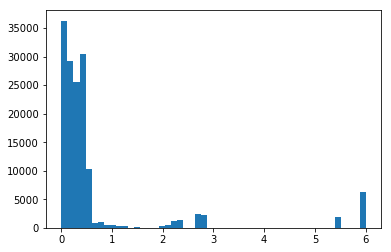

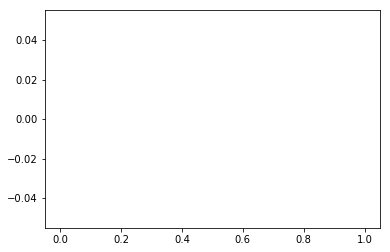

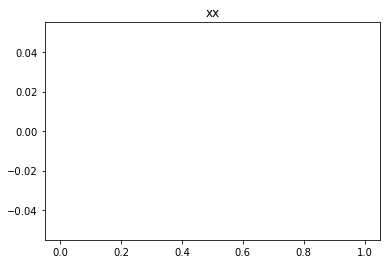

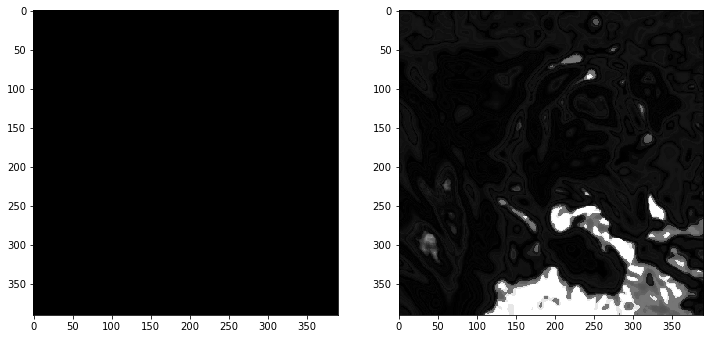

6.0

In [12]:
img4   = np.zeros(img2X.shape)

step    = 150
binsMin = min(img1.min(),img2X.min())
binsMax = max(img1.max(),img2X.max())
binsStep= float(binsMax-binsMin)/step

bins = [binsMin+ii*binsStep for ii in range(step)] 
#print(bins,binsMin,binsMax,img1.min())
for cc in range(img1.shape[2]) :
    #cc = 2
    hist1, bins1, _ = plt.hist(img1 [ar0:arL,ac0:acL,cc].ravel(),bins=bins)
    hist2, bins2, _ = plt.hist(img2X [ar0:arL,ac0:acL,cc].ravel(),bins=bins)
    plt.close()
    
    dh = np.abs((hist1-hist2)); dh[dh>2].shape
    #plt.hist(dh[dh>0].ravel(),bins=50); plt.show()
    dh = np.abs((hist1-hist2)); dh[dh>0].shape
    img4cc = img4[:,:,cc]
    for ii,ddhh in enumerate(dh[:-1]) :
        #print(ii,ddhh,hist1[ii])
        if (ddhh>=1.0) and hist1[ii]>0 : 
            img4cc[(img1[:,:,cc]>=bins[ii])&(img1[:,:,cc]<bins[ii+1])] += 2*float(ddhh)/(hist1[ii]+hist2[ii])
    img4[:,:,cc] = img4cc.copy()
    #plt.hist(img4[:,:,cc].ravel(),bins=150); plt.show()
    #plt.imshow(img4[:,:,cc]); plt.show()
    
img4cc[:,:] = np.abs(1.0*img4[:,:,0] + 1.0*img4[:,:,1] * 1.0*img4[:,:,2])
plt.hist(img4cc[img4cc>0.0].ravel(),bins=50); plt.show()
plt.hist(img4cc[img3>0.5].ravel(),bins=50); plt.show()

plt.hist(img4[:,:,0][img3>0.5].ravel(),bins=50);  plt.title('xx');plt.show()

plt.figure(figsize=(12,12))
#img4cc[img4cc>0.5] = 1
plt.subplot(1,2,1); plt.imshow(img3,'gray')
plt.subplot(1,2,2); plt.imshow(img4cc,'gray'); 
plt.show()
img4cc.max()

In [930]:
img4.max()

2.8571428571428572

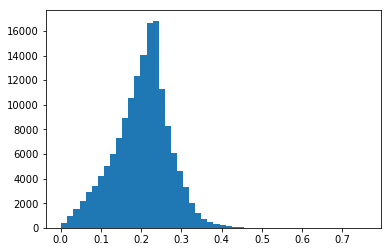

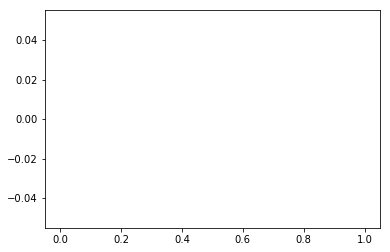

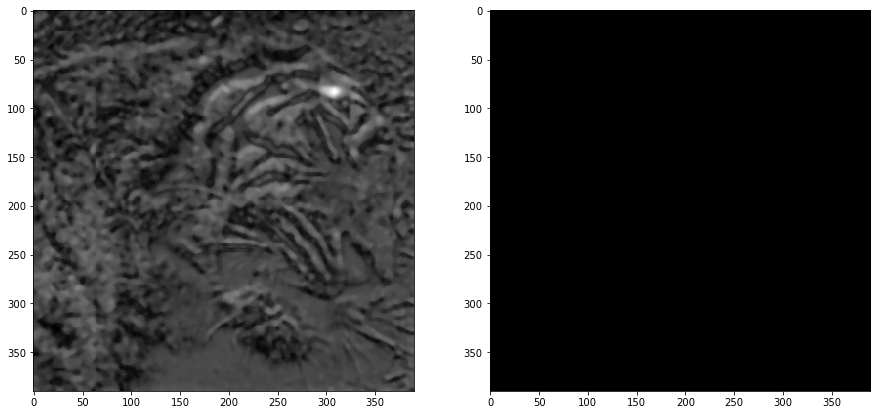

In [14]:
a = np.abs(img2X-img1)
b = np.float32(np.sqrt(a[:,:,0]**2+a[:,:,1]**2+a[:,:,2]**2))
b = np.float32(np.sqrt(a[:,:,0]+a[:,:,1]+a[:,:,2]))
b = np.float32(np.sqrt(a[:,:,1]))
#b = np.float32(np.sqrt(a.max(axis=(2))))
#b[b<13.0] = 0.0
#b = cv2.GaussianBlur(b,(3,3),0)
#b = cv2.boxFilter(b,-1,(5,5))
plt.hist(b.ravel(),bins=50); plt.show()
plt.hist(b[img3>0.5].ravel(),bins=50); plt.show()
#plt.imshow(b); plt.show()
#b.reshape(b.shape+(1,)).shape
b[b>10] = 0
b = cv2.medianBlur(b,5,0)
#b = cv2.boxFilter(b,-1,(5,5))
plt.figure(figsize=(15,12))
plt.subplot(1,2,1); plt.imshow(b,'gray');
plt.subplot(1,2,2); plt.imshow(img3,'gray'); 
plt.show()
#b.dtype